   Maturity (years)  Discount Factor  Zero-Coupon Yield (%)
0              0.08           0.9964                 4.3378
1              0.25           0.9893                 4.3132
2              0.50           0.9789                 4.2652
3              1.00           0.9586                 4.2281
4              2.00           0.9186                 4.2450
5              3.00           0.8791                 4.2962
6              5.00           0.8034                 4.3781
7              7.00           0.7313                 4.4713
8             10.00           0.6335                 4.5644
9             30.00           0.2380                 4.7856


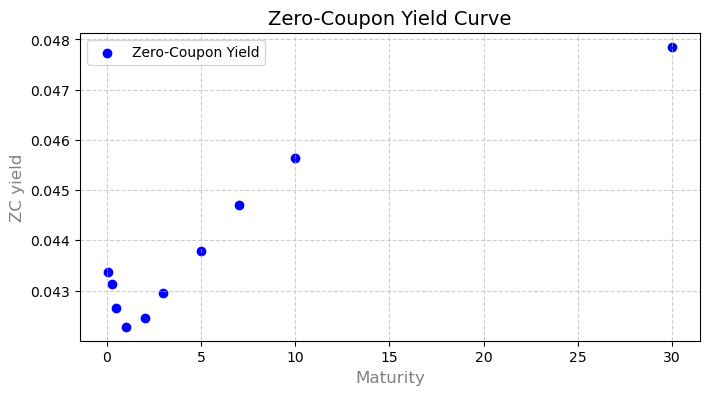

In [1]:
# 1
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pandas as pd

class ZeroCouponCalculator:
    def __init__(self):
        # Store yields for bills (expressed as percentages)
        self.bills_yields = {
            1/12: 4.33,  # 1-month
            1/4: 4.29,   # 3-month
            1/2: 4.22,   # 6-month
            1.0: 4.14    # 1-year
        }
        
        # Calculate discount factors for bills using yield
        self.bills_discount_factors = {
            t: 1 - y / 100 * t for t, y in self.bills_yields.items()
        }
        
        # Store known rates for bonds
        self.bond_rates = {
            2.0: 4.29,
            3.0: 4.34,
            5.0: 4.42,
            7.0: 4.51,
            10.0: 4.60,
            30.0: 4.82
        }
        
    def get_discount_factor(self, t):
        """
        Get discount factor for time t
        For t <= 1: retrieve from bills_discount_factors
        For 1 < t: interpolate if needed
        """
        if t in self.bills_discount_factors:
            return self.bills_discount_factors[t]
        elif t <= 1:
            # Find surrounding points and interpolate
            times = sorted(self.bills_discount_factors.keys())
            idx = np.searchsorted(times, t)
            t1, t2 = times[idx-1], times[idx]
            d1 = self.bills_discount_factors[t1]
            d2 = self.bills_discount_factors[t2]
            return (d1+d2)/2
        return None

    def calculate_bond_discount_factor(self, T, rate):
        """Calculate discount factor for a bond with maturity T"""
        rate = rate / 100  # Convert to decimal
        
        def bond_price_equation(P):
            price = 0
            # Calculate semi-annual coupon payments
            for i in range(1, int(T * 2) + 1):
                t = i / 2
                if t <= 1:
                    # Use stored bills discount factors
                    df = self.get_discount_factor(t)
                elif t > 1 and t < T:
                    if t.is_integer():
                        if t in self.bond_discount_factors:
                            df = self.bond_discount_factors[t]
                        else:
                            df = P ** (t / T)
                    else:
                        # For non-integer t > 1, use average of surrounding points
                        t_floor = int(t)
                        t_ceil = t_floor + 1
                        if t_floor == 1:
                            df_floor = self.bills_discount_factors[1.0]
                        else:
                            df_floor = self.bond_discount_factors.get(t_floor, P ** (t_floor / T))
                        df_ceil = self.bond_discount_factors.get(t_ceil, P ** (t_ceil / T))
                        df = (df_floor + df_ceil) / 2
                else:  # t = T
                    df = P
                
                price += (rate * 100 / 2) * df
            
            # Add final payment
            price += 100 * P
            return price - 100
        
        # Solve for the discount factor
        initial_guess = 1 / (1 + rate) ** T
        P = fsolve(bond_price_equation, x0=initial_guess)[0]
        return P

    def calculate_all_discount_factors(self):
        """Calculate discount factors for all bonds"""
        self.bond_discount_factors = {}
        
        # Calculate discount factors in order of maturity
        for T in sorted(self.bond_rates.keys()):
            P = self.calculate_bond_discount_factor(T, self.bond_rates[T])
            self.bond_discount_factors[T] = P
            
        return self.bond_discount_factors

    def calculate_zero_coupon_yields(self):
        """Calculate zero-coupon yields for all maturities"""
        # Calculate bond discount factors
        self.calculate_all_discount_factors()
        
        # Combine all discount factors
        all_discount_factors = {**self.bills_discount_factors, **self.bond_discount_factors}
        
        # Calculate zero-coupon yields
        zero_coupon_yields = {}
        for t, df in sorted(all_discount_factors.items()):
            zcy = -1 / t * np.log(df) * 100
            zero_coupon_yields[t] = zcy
        
        return zero_coupon_yields

def main():
    calculator = ZeroCouponCalculator()
    zero_coupon_yields = calculator.calculate_zero_coupon_yields()

    # Prepare data for DataFrame
    data = []
    for t in sorted(zero_coupon_yields.keys()):
        df = calculator.bills_discount_factors.get(t) or calculator.bond_discount_factors.get(t)
        zcy = zero_coupon_yields[t]
        data.append([round(t, 2), round(df, 4), round(zcy, 4)])

    # Create DataFrame
    df_results = pd.DataFrame(data, columns=["Maturity (years)", "Discount Factor", "Zero-Coupon Yield (%)"])

    # Display DataFrame
    print(df_results)

    # Plot scatter chart
    plt.figure(figsize=(8, 4))
    plt.scatter(df_results["Maturity (years)"], df_results["Zero-Coupon Yield (%)"] / 100, color='blue', label="Zero-Coupon Yield")

    # Labels and formatting
    plt.xlabel("Maturity", fontsize=12, color='gray')
    plt.ylabel("ZC yield", fontsize=12, color='gray')
    plt.title("Zero-Coupon Yield Curve", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Display the chart
    plt.show()

# Run the main function
main()


Nelson-Siegel-Svensson Fitting Results:
              Value
β₀         0.048674
β₁        -0.005336
β₂         0.993158
β₃        -1.006863
τ          0.995946
θ          1.004052
Objective   2.9e-06


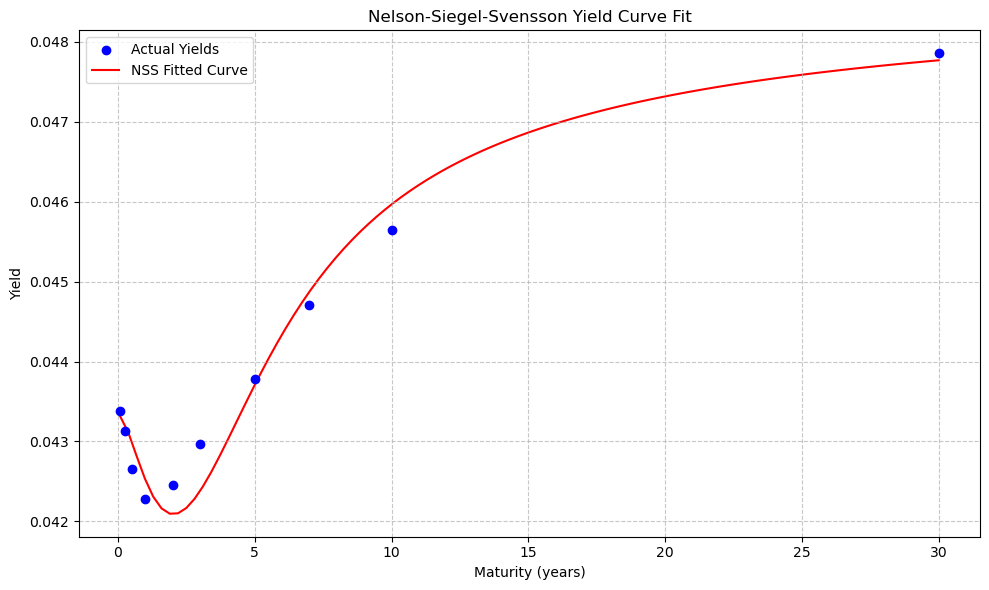

In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def nss_yield(t, params):
    """
    Calculate yield using Nelson-Siegel-Svensson function
    params: [a, b, c, d, tau, theta]
    """
    a, b, c, d, tau, theta = params
    
    # Handle very small t values to avoid division by zero
    if t < 1e-10:
        t = 1e-10
    
    factor1 = (1 - np.exp(-t/tau)) / (t/tau)
    factor2 = factor1 - np.exp(-t/tau)
    factor3 = (1 - np.exp(-t/theta)) / (t/theta) - np.exp(-t/theta)
    
    return a + b*factor1 + c*factor2 + d*factor3

def objective_function(params, maturities, yields, weighted=True):
    """
    Calculate weighted sum of squared errors between actual and fitted yields
    With special weighting for short-end (1/t) and long-end (t) of the curve
    """
    fitted_yields = np.array([nss_yield(t, params) for t in maturities])
    errors = yields - fitted_yields
    
    if weighted:
        # Apply weights: 1/t for short end, t for long end
        # Use maturity of 2 years as the threshold between short and long end
        threshold = 2.0
        weights = np.where(maturities <= threshold, 
                          1/maturities,  # Short end: weight by 1/t
                          maturities)    # Long end: weight by t
        
        # Apply weights to squared errors
        weighted_errors = errors * errors * weights
        return np.sum(weighted_errors)
    else:
        return np.sum(errors * errors)

def fit_nss(maturities, yields, weighted=True):
    """
    Fit Nelson-Siegel-Svensson model to the yield curve
    """
    # Initial parameter guess
    initial_guess = [
        0.035,  # a (long-term level)
        0.01,   # b
        1.0,    # c
        -1.0,   # d
        1.0,    # tau
        1.0     # theta
    ]
    
    # Parameter bounds
    bounds = [
        (0, 0.1),     # a
        (-0.1, 0.1),  # b
        (-2, 2),      # c
        (-2, 2),      # d
        (0.1, 10),    # tau
        (0.1, 10)     # theta
    ]
    
    # Minimize objective function
    result = minimize(
        objective_function,
        initial_guess,
        args=(maturities, yields, weighted),
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    return result


calculator = ZeroCouponCalculator()
zero_coupon_yields = calculator.calculate_zero_coupon_yields()

# Convert dictionary to arrays for fitting
maturities = np.array(list(zero_coupon_yields.keys()))
yields = np.array(list(zero_coupon_yields.values())) / 100  # Convert to decimal

# Fit NSS model with weighted objective function
result = fit_nss(maturities, yields, weighted=True)

# Print results in the requested format
# Create DataFrame
results_df = pd.DataFrame({
    'Value': result.x
}, index=['β₀', 'β₁', 'β₂', 'β₃', 'τ', 'θ'])
# Add objective function value at the bottom
obj_value = f"{result.fun:.1e}" 
results_df.loc['Objective'] = obj_value

print("\nNelson-Siegel-Svensson Fitting Results:")
print(results_df)

# Generate fitted curve for plotting
t_fine = np.linspace(min(maturities), max(maturities), 100)
fitted_yields = [nss_yield(t, result.x) for t in t_fine]

# Plot results
plt.figure(figsize=(10, 6))

# Plot actual yields
plt.scatter(maturities, yields, color='blue', label='Actual Yields', zorder=2)

# Plot fitted curve
plt.plot(t_fine, fitted_yields, 'r-', label='NSS Fitted Curve', zorder=1)

plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('Nelson-Siegel-Svensson Yield Curve Fit')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd

class ImprovedBrigoMercurio:
    def __init__(self, t=0.003):
        self.t = t
        self.K_ratios = [0.95, 1.0, 1.05]
        self.T_years = [1, 3, 5, 7, 10, 20]
        
        # Market implied volatilities
        self.vol_market = np.array([
            [0.157, 0.152, 0.146],  # 1yr
            [0.176, 0.164, 0.157],  # 3yr
            [0.175, 0.161, 0.158],  # 5yr
            [0.168, 0.156, 0.152],  # 7yr
            [0.155, 0.148, 0.140],  # 10yr
            [0.142, 0.126, 0.121]   # 20yr
        ])
        
        self.zc_calculator = ZeroCouponCalculator()
        self._initialize_market_data()
        
    def _initialize_market_data(self):
        """Initialize discount factors and forward rates"""
        df_dict = {**self.zc_calculator.bills_discount_factors,
                  **self.zc_calculator.calculate_all_discount_factors()}
        
        self.discount_factors_dict = df_dict
        maturities = sorted(df_dict.keys())
        factors = [df_dict[t] for t in maturities]
        self.discount_factors = interp1d(maturities, factors, kind='cubic', 
                                       fill_value='extrapolate')

    def get_forward_rate(self, T):
        """Calculate forward rate"""
        dt = 0.01
        P_T = float(self.discount_factors(T))
        P_T_plus_dt = float(self.discount_factors(T + dt))
        return -(1/dt) * np.log(P_T_plus_dt/P_T)

    def black_formula(self, F, K, T, sigma, P_T):
        """Black's formula for cap price"""
        if abs(F - K) < 1e-10:
            return P_T * sigma * np.sqrt(T/2*np.pi)
        
        d1 = (np.log(F/K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        return P_T * (F * norm.cdf(d1) - K * norm.cdf(d2))

    def enhanced_volatility(self, T, params):
        """
        Enhanced volatility function with hump shape
        Combines short-term, medium-term and long-term components
        """
        theta, kappa, sigma, v0, alpha, beta = params
        
        # Short-term component (mean-reversion)
        short_term = v0 * np.exp(-kappa * T)
        
        # Medium-term component (hump)
        hump = alpha * T * np.exp(-beta * T)
        
        # Long-term component (level)
        long_term = theta * (1 - np.exp(-kappa * T))
        
        # Volatility of volatility effect
        vol_effect = (sigma**2 / (2 * kappa)) * (1 - np.exp(-kappa * T))**2
        
        total_var = short_term + hump + long_term + vol_effect
        return np.sqrt(max(total_var, 1e-10))

    def calculate_model_quantities(self, params):
        """Calculate model prices and volatilities"""
        model_caps = np.zeros((len(self.T_years), len(self.K_ratios)))
        model_vols = np.zeros_like(model_caps)
        market_caps = np.zeros_like(model_caps)
        
        for i, T in enumerate(self.T_years):
            F = self.get_forward_rate(T)
            P_T = float(self.discount_factors(T))
            
            for j, K_ratio in enumerate(self.K_ratios):
                K = K_ratio * F
                
                # Calculate model volatility
                vol_model = self.volatility(T, params)
                cap_model = self.black_formula(F, K, T, vol_model, P_T)
                
                # Calculate market cap price
                vol_market = self.vol_market[i, j]
                cap_market = self.black_formula(F, K, T, vol_market, P_T)
                
                # Implied volatility calculation
                def implied_vol_objective(sigma):
                    return self.black_formula(F, K, T, sigma, P_T) - cap_model
                
                # Find model implied volatility through numerical inversion
                try:
                    model_implied_vol = opt.brentq(implied_vol_objective, 0.0001, 1.0)
                except ValueError:
                    model_implied_vol = vol_model  # fallback if root finding fails
                
                model_caps[i, j] = cap_model
                model_vols[i, j] = model_implied_vol  # Store implied vol instead of direct vol
                market_caps[i, j] = cap_market
        
        return model_caps, model_vols, market_caps
    
    def calibrate(self):
        """Calibrate model parameters"""
        initial_guesses = [
            [0.02, 0.5, 0.2, 0.04],  # θ, κ, σ, v0
            [0.03, 0.8, 0.15, 0.03],
            [0.025, 0.6, 0.18, 0.035]
        ]
        
        bounds = [
            (0.001, 0.2),   # theta - widened range
            (0.1, 10.0),    # kappa - widened range
            (0.01, 1.0),    # sigma - widened range
            (0.001, 0.2)    # v0 - widened range
        ]
        
        best_result = None
        best_error = float('inf')
        
        for guess in initial_guesses:
            result = opt.minimize(self.objective_function, x0=guess,
                                method='L-BFGS-B', bounds=bounds,
                                options={'maxiter': 1000})
            
            if result.fun < best_error:
                best_error = result.fun
                best_result = result
        
        return best_result

    def objective_function(self, params):
        """
        Enhanced objective function with both price and volatility fitting
        Adds more weight to volatility fitting
        """
        model_caps, model_vols, market_caps = self.calculate_model_quantities(params)
        
        # Price error
        price_error = 0
        for i in range(len(self.T_years)):
            for j in range(len(self.K_ratios)):
                if market_caps[i, j] != 0:
                    relative_error = (model_caps[i, j] - market_caps[i, j]) / market_caps[i, j]
                    price_error += relative_error ** 2
        
        # Volatility error (with higher weight)
        vol_error = 0
        for i in range(len(self.T_years)):
            for j in range(len(self.K_ratios)):
                relative_error = (model_vols[i, j] - self.vol_market[i, j]) / self.vol_market[i, j]
                vol_error += relative_error ** 2
        
        # Regularization term for stability
        theta, kappa, sigma, v0, alpha, beta = params
        regularization = 0.01 * (theta**2 + kappa**2 + sigma**2 + v0**2 + alpha**2 + beta**2)
        
        # Combined objective with higher weight on volatility fitting
        return 0.3 * price_error + 0.6 * vol_error + 0.1 * regularization


    def plot_results(self, params):
        """Plot calibration results"""
        model_caps, model_vols, market_caps = self.calculate_model_quantities(params)
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        strike_labels = ['ITM (0.95Kf)', 'ATM (Kf)', 'OTM (1.05Kf)']
        
        # Plot cap prices
        for j in range(3):
            ax = axes[0, j]
            ax.plot(self.T_years, market_caps[:, j], 'o-', label='Market', color='blue')
            ax.plot(self.T_years, model_caps[:, j], '--', label='Model', color='red')
            ax.set_title(f'Cap Prices - {strike_labels[j]}')
            ax.set_xlabel('Maturity (years)')
            ax.set_ylabel('Price')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        # Plot implied volatilities
        for j in range(3):
            ax = axes[1, j]
            ax.plot(self.T_years, self.vol_market[:, j], 'o-', 
                   label='Market', color='blue')
            ax.plot(self.T_years, model_vols[:, j], '--', 
                   label='Model', color='red')
            ax.set_title(f'Implied Volatility - {strike_labels[j]}')
            ax.set_xlabel('Maturity (years)')
            ax.set_ylabel('Implied Volatility')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        plt.tight_layout()
        plt.show()

def main():
    model = ImprovedBrigoMercurio()
    result = model.calibrate()
    
    # Display parameters
    param_names = ['θ (level)', 'κ (speed)', 'σ (vol)', 'v0 (init)', 
                  'α (hump mag)', 'β (hump loc)']
    param_data = [[name, f"{val:.6f}"] for name, val in zip(param_names, result.x)]
    param_data.append(['Objective Value', f"{result.fun:.6f}"])
    
    df_params = pd.DataFrame(param_data, columns=['Parameter', 'Value'])
    print("\nCalibrated Parameters:")
    print(df_params.to_string(index=False))
    
    # Plot results
    model.plot_results(result.x)

if __name__ == "__main__":
    main()

AttributeError: 'ImprovedBrigoMercurio' object has no attribute 'volatility'


Calibrated Parameters:
      Parameter    Value
      θ (theta) 0.020255
      κ (kappa) 2.104493
      σ (sigma) 0.087399
             v0 0.024425
Objective Value 0.171075


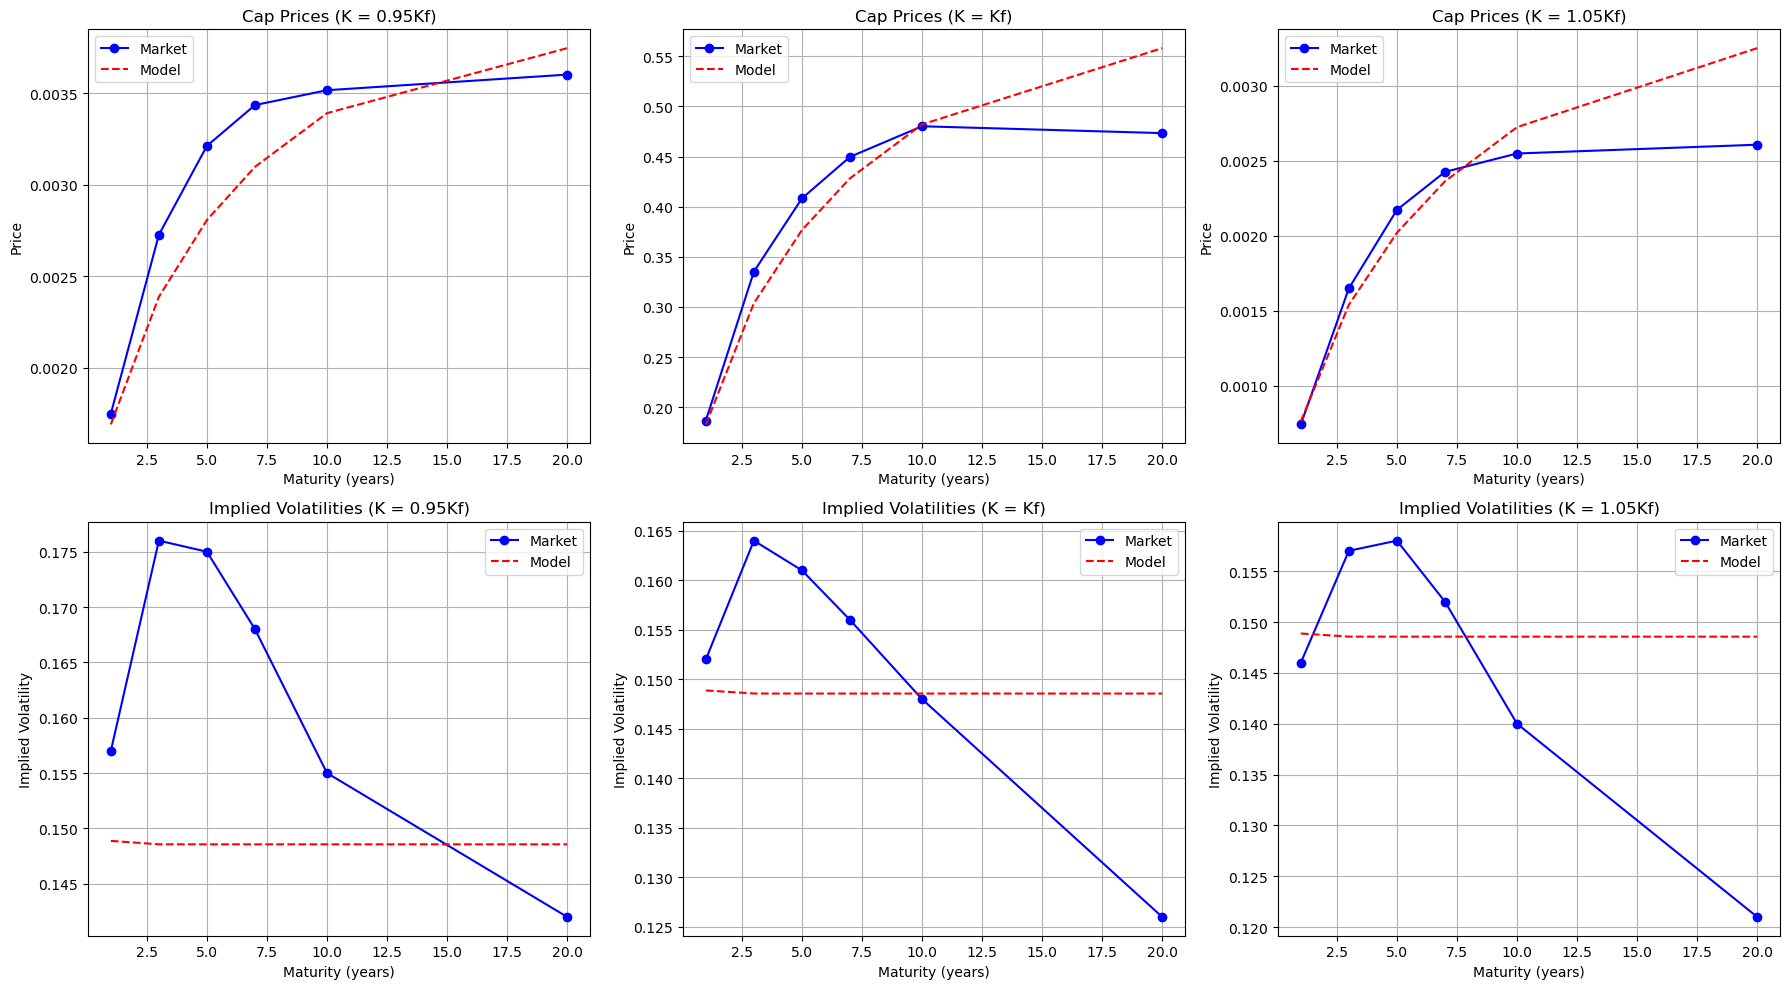

In [24]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd

class BrigoMercurio:
    def __init__(self, t=0.003):
        self.t = t
        self.K_ratios = [0.95, 1.0, 1.05]
        self.T_years = [1, 3, 5, 7, 10, 20]
        
        # Market implied volatilities as given in the question
        self.vol_market = np.array([
            [0.157, 0.152, 0.146],  # 1yr
            [0.176, 0.164, 0.157],  # 3yr
            [0.175, 0.161, 0.158],  # 5yr
            [0.168, 0.156, 0.152],  # 7yr
            [0.155, 0.148, 0.140],  # 10yr
            [0.142, 0.126, 0.121]   # 20yr
        ])
        
        # Initialize discount factors (you would need to implement ZeroCouponCalculator)
        self._initialize_market_data()
        
    def _initialize_market_data(self):
        """Initialize discount factors with sample data"""
        # Sample discount factors for demonstration
        years = np.linspace(0, 20, 21)
        factors = np.exp(-0.02 * years)  # Assuming 2% continuous rate for example
        self.discount_factors = interp1d(years, factors, kind='cubic', 
                                       fill_value='extrapolate')

    def get_forward_rate(self, T):
        """Calculate forward rate"""
        dt = 0.01
        P_T = float(self.discount_factors(T))
        P_T_plus_dt = float(self.discount_factors(T + dt))
        return -(1/dt) * np.log(P_T_plus_dt/P_T)

    def black_formula(self, F, K, T, sigma, P_T):
        """Black's formula for cap price"""
        if abs(F - K) < 1e-10:
            return P_T * sigma * np.sqrt(T/2*np.pi)
        
        d1 = (np.log(F/K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        return P_T * (F * norm.cdf(d1) - K * norm.cdf(d2))

    def volatility(self, T, params):
        """
        Standard Brigo-Mercurio volatility function
        params: [theta, kappa, sigma, v0]
        """
        theta, kappa, sigma, v0 = params
        
        # Mean reversion component
        mean_rev = v0 * np.exp(-kappa * T)
        
        # Long-term component
        long_term = theta * (1 - np.exp(-kappa * T))
        
        # Volatility of volatility effect
        vol_effect = (sigma**2 / (2 * kappa)) * (1 - np.exp(-kappa * T))**2
        
        total_var = mean_rev + long_term + vol_effect
        return np.sqrt(max(total_var, 1e-10))

    def calculate_model_quantities(self, params):
        """Calculate model prices and volatilities"""
        model_caps = np.zeros((len(self.T_years), len(self.K_ratios)))
        model_vols = np.zeros_like(model_caps)
        market_caps = np.zeros_like(model_caps)
        
        for i, T in enumerate(self.T_years):
            F = self.get_forward_rate(T)
            P_T = float(self.discount_factors(T))
            
            for j, K_ratio in enumerate(self.K_ratios):
                K = K_ratio * F
                
                # Calculate model volatility
                vol_model = self.volatility(T, params)
                cap_model = self.black_formula(F, K, T, vol_model, P_T)
                
                # Calculate market cap price
                vol_market = self.vol_market[i, j]
                cap_market = self.black_formula(F, K, T, vol_market, P_T)
                
                # Implied volatility calculation
                def implied_vol_objective(sigma):
                    return self.black_formula(F, K, T, sigma, P_T) - cap_model
                
                # Find model implied volatility through numerical inversion
                try:
                    model_implied_vol = opt.brentq(implied_vol_objective, 0.0001, 1.0)
                except ValueError:
                    model_implied_vol = vol_model  # fallback if root finding fails
                
                model_caps[i, j] = cap_model
                model_vols[i, j] = model_implied_vol  # Store implied vol instead of direct vol
                market_caps[i, j] = cap_market
        
        return model_caps, model_vols, market_caps

    def objective_function(self, params):
        """
        Objective function as specified in the question:
        Minimizing relative pricing error on cap market prices
        """
        model_caps, _, market_caps = self.calculate_model_quantities(params)
        
        relative_error = 0
        for i in range(len(self.T_years)):
            for j in range(len(self.K_ratios)):
                if market_caps[i, j] != 0:
                    error = (model_caps[i, j] - market_caps[i, j]) / market_caps[i, j]
                    relative_error += error ** 2
        
        return relative_error


    def calibrate(self):
        """Calibrate model parameters"""
        initial_guesses = [
            [0.02, 0.5, 0.2, 0.04],  # θ, κ, σ, v0
            [0.03, 0.8, 0.15, 0.03],
            [0.025, 0.6, 0.18, 0.035]
        ]
        
        bounds = [
            (0.001, 0.2),   # theta - widened range
            (0.1, 10.0),    # kappa - widened range
            (0.01, 1.0),    # sigma - widened range
            (0.001, 0.2)    # v0 - widened range
        ]
        
        best_result = None
        best_error = float('inf')
        
        for guess in initial_guesses:
            result = opt.minimize(self.objective_function, x0=guess,
                                method='L-BFGS-B', bounds=bounds,
                                options={'maxiter': 1000})
            
            if result.fun < best_error:
                best_error = result.fun
                best_result = result
        
        return best_result


    def plot_results(self, params):
        """Plot calibration results with separate plots for each strike"""
        model_caps, model_vols, market_caps = self.calculate_model_quantities(params)
        
        # Create 6 subplots (2x3 grid)
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        strike_labels = ['0.95Kf', 'Kf', '1.05Kf']
        
        # Plot cap prices (top row)
        for j in range(3):
            ax = axes[0, j]
            ax.plot(self.T_years, market_caps[:, j], 'o-', 
                    label='Market', color='blue')
            ax.plot(self.T_years, model_caps[:, j], '--', 
                    label='Model', color='red')
            
            ax.set_title(f'Cap Prices (K = {strike_labels[j]})')
            ax.set_xlabel('Maturity (years)')
            ax.set_ylabel('Price')
            ax.grid(True)
            ax.legend()
        
        # Plot implied volatilities (bottom row)
        for j in range(3):
            ax = axes[1, j]
            ax.plot(self.T_years, self.vol_market[:, j], 'o-', 
                    label='Market', color='blue')
            ax.plot(self.T_years, model_vols[:, j], '--', 
                    label='Model', color='red')
            
            ax.set_title(f'Implied Volatilities (K = {strike_labels[j]})')
            ax.set_xlabel('Maturity (years)')
            ax.set_ylabel('Implied Volatility')
            ax.grid(True)
            ax.legend()
        
        plt.tight_layout()
        plt.show()
        
    def analyze_volatility_components(self, params):
        """Analyze how each component of the volatility varies with maturity"""
        theta, kappa, sigma, v0 = params
        T_range = np.linspace(0, 20, 100)
        
        components = {
            'Mean Reversion': [],
            'Long Term': [],
            'Vol of Vol': [],
            'Total Volatility': []
        }
    
        for T in T_range:
            # Mean reversion
            mean_rev = v0 * np.exp(-kappa * T)
            
            # Long-term
            long_term = theta * (1 - np.exp(-kappa * T))
            
            # Vol of vol
            vol_vol = (sigma**2 / (2 * kappa)) * (1 - np.exp(-kappa * T))**2
            
            # Total variance
            total_var = mean_rev + long_term + vol_vol
            total_vol = np.sqrt(max(total_var, 1e-10))
            
            components['Mean Reversion'].append(mean_rev)
            components['Long Term'].append(long_term)
            components['Vol of Vol'].append(vol_vol)
            components['Total Volatility'].append(total_vol)
        
        # Plot components
        plt.figure(figsize=(12, 6))
        for name, values in components.items():
            plt.plot(T_range, values, label=name)
        
        plt.title('Volatility Components Analysis')
        plt.xlabel('Time to Maturity (years)')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.show()
        
        # Print some specific values
        print("\nVolatility Components at Key Maturities:")
        for T in [1, 5, 10, 20]:
            mean_rev = v0 * np.exp(-kappa * T)
            long_term = theta * (1 - np.exp(-kappa * T))
            vol_vol = (sigma**2 / (2 * kappa)) * (1 - np.exp(-kappa * T))**2
            total_var = mean_rev + long_term + vol_vol
            total_vol = np.sqrt(max(total_var, 1e-10))
            
            print(f"\nT = {T} years:")
            print(f"Mean Reversion: {mean_rev:.6f}")
            print(f"Long Term: {long_term:.6f}")
            print(f"Vol of Vol: {vol_vol:.6f}")
            print(f"Total Volatility: {total_vol:.6f}")

# Add this to the main function:
def main():
    model = BrigoMercurio()
    result = model.calibrate()
    
    print("\nAnalyzing volatility components...")
    model.analyze_volatility_components(result.x)
    
    # Rest of the main function...

def main():
    model = BrigoMercurio()
    result = model.calibrate()
    
    # Display parameters
    param_names = ['θ (theta)', 'κ (kappa)', 'σ (sigma)', 'v0']
    param_data = [[name, f"{val:.6f}"] for name, val in zip(param_names, result.x)]
    param_data.append(['Objective Value', f"{result.fun:.6f}"])
    
    df_params = pd.DataFrame(param_data, columns=['Parameter', 'Value'])
    print("\nCalibrated Parameters:")
    print(df_params.to_string(index=False))
    
    # Plot results
    model.plot_results(result.x)

if __name__ == "__main__":
    main()


Descriptive Statistics for Zero-Coupon Yields:
         Mean  Std Dev      Q1  Median      Q3
0.25y  0.0242   0.0229  0.0019  0.0166  0.0521
0.5y   0.0242   0.0223  0.0017  0.0165  0.0508
1y     0.0239   0.0211  0.0016  0.0170  0.0473
3y     0.0230   0.0175  0.0040  0.0169  0.0412
5y     0.0232   0.0154  0.0082  0.0176  0.0392
10y    0.0253   0.0133  0.0149  0.0194  0.0383
30y    0.0302   0.0109  0.0210  0.0252  0.0403


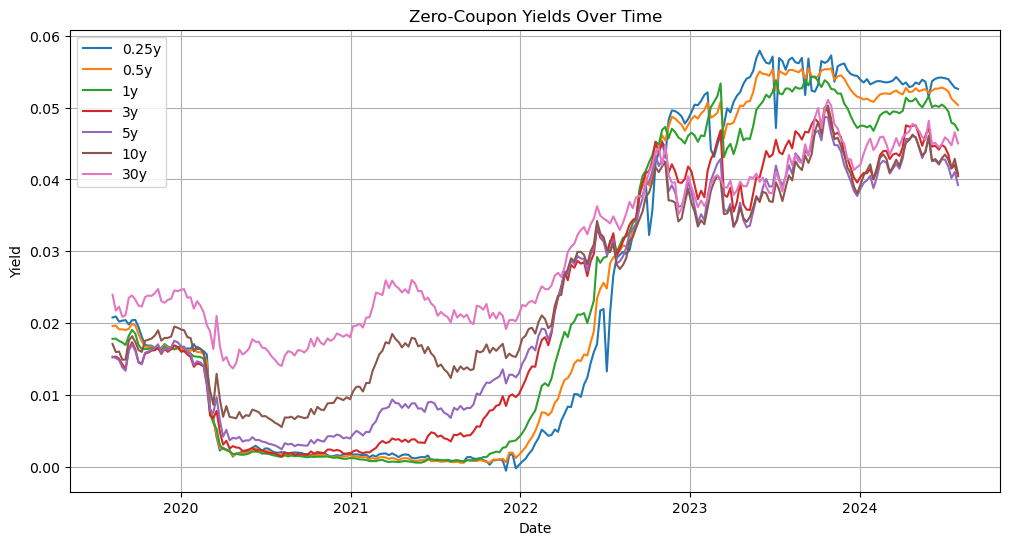

In [27]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def nss_yield(beta0, beta1, beta2, beta3, tau1, tau2, maturity):
    """Calculate yield using Nelson-Siegel-Svensson model"""
    try:
        term1 = beta0
        term2 = beta1 * ((1 - np.exp(-maturity/tau1))/(maturity/tau1))
        term3 = beta2 * ((1 - np.exp(-maturity/tau1))/(maturity/tau1) - np.exp(-maturity/tau1))
        term4 = beta3 * ((1 - np.exp(-maturity/tau2))/(maturity/tau2) - np.exp(-maturity/tau2))
        return float(term1 + term2 + term3 + term4)
    except Exception as e:
        print(f"Error in calculation: {str(e)}")
        return np.nan

# Read the Excel file
df = pd.read_excel('TP1 data 60201 W2025.xlsx', 
                   dtype={
                       'BETA0': float, 'BETA1': float, 'BETA2': float,
                       'BETA3': float, 'TAU1': float, 'TAU2': float
                   })

# Convert parameters to numpy arrays for vectorized operations
beta0 = df['BETA0'].to_numpy()/100
beta1 = df['BETA1'].to_numpy()/100
beta2 = df['BETA2'].to_numpy()/100
beta3 = df['BETA3'].to_numpy()/100
tau1 = df['TAU1'].to_numpy()
tau2 = df['TAU2'].to_numpy()

# Define maturities (in years)
maturities = [0.25, 0.5, 1, 3, 5, 10, 30]

# Calculate yields for each maturity using vectorized operations
yields_data = {}
for maturity in maturities:
    yields = np.zeros(len(df))
    for i in range(len(df)):
        yields[i] = nss_yield(
            beta0[i], beta1[i], beta2[i], beta3[i],
            tau1[i], tau2[i], maturity
        )
    yields_data[f'{maturity}y'] = yields

# Create DataFrame with calculated yields
yields_df = pd.DataFrame(yields_data, index=df['Date'])

# Calculate descriptive statistics
stats_df = pd.DataFrame({
    'Mean': yields_df.mean(),
    'Std Dev': yields_df.std(),
    'Q1': yields_df.quantile(0.25),
    'Median': yields_df.quantile(0.50),
    'Q3': yields_df.quantile(0.75)
})

# Format statistics to 4 decimal places
stats_df = stats_df.round(4)

print("\nDescriptive Statistics for Zero-Coupon Yields:")
print("=============================================")
print(stats_df)

# Create visualization
plt.figure(figsize=(12, 6))
for col in yields_df.columns:
    plt.plot(yields_df.index, yields_df[col], label=col)

plt.title('Zero-Coupon Yields Over Time')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()


Estimated CIR Model Parameters:
        Parameter      Estimate  Standard Error
0           Kappa  1.000000e-01             1.0
1           Theta  5.000000e-02             1.0
2           Sigma  2.000000e-02             1.0
3               A  1.000000e-02             1.0
4               B -5.000000e-01             1.0
5  Log-Likelihood -8.568423e+45             NaN

Measurement Error Statistics:
       Mean Error  Variance of Error
0.25y      0.0263             0.0005
0.5y       0.0263             0.0005
1y         0.0260             0.0004
3y         0.0251             0.0003
5y         0.0253             0.0002
10y        0.0274             0.0002
30y        0.0323             0.0001


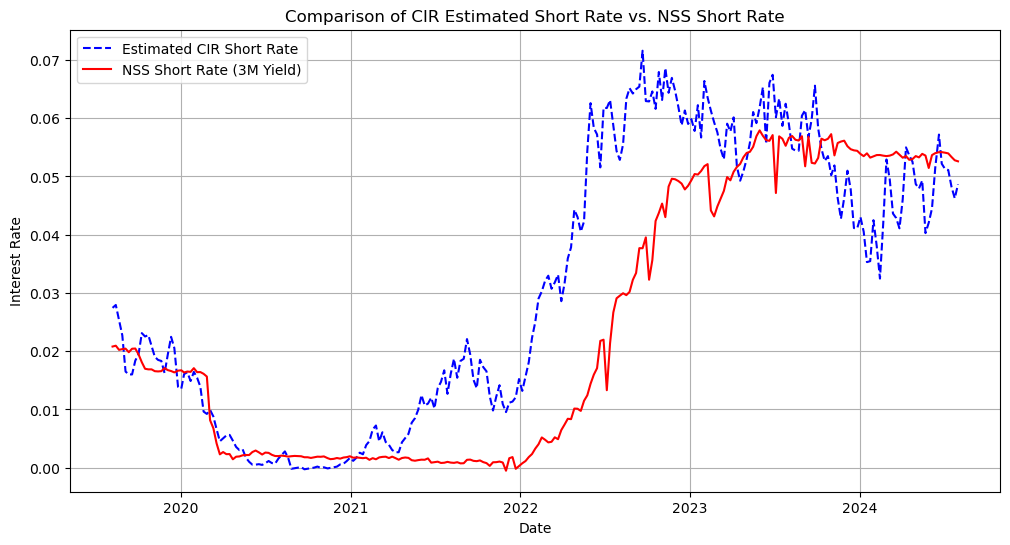

In [109]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm

# Load data (assuming yields_df from previous script)
yields_df = yields_df.dropna()  # Ensure no NaN values

# Define maturities
maturities = np.array([0.25, 0.5, 1, 3, 5, 10, 30])
dt = 1 / 52  # Weekly data

# Initial guesses for parameters
init_params = [0.1, 0.05, 0.02, 0.01, -0.5]   # [kappa, theta, sigma, A, B]

def cir_kalman_filter(params, yields):
    """Kalman Filter to estimate CIR model parameters"""
    kappa, theta, sigma, A, B = params
    n_obs = len(yields)
    n_mat = len(maturities)
    
    # Initialize state variables
    X_t = np.mean(yields.values[:, 0])  # Start with the mean of short-term yield
    P_t = sigma ** 2  # Initial variance
    log_likelihood = 0
    measurement_error_var = np.zeros(n_mat)  # To store measurement errors

    # Kalman Filter loop
    for t in range(n_obs):
        # Prediction Step
        X_t_pred = X_t + kappa * (theta - X_t) * dt
        P_t_pred = P_t + sigma ** 2 * dt  # Approximate variance update

        # Measurement Equation
        Y_pred = A + B * X_t_pred
        measurement_error = yields.iloc[t, :] - Y_pred
        measurement_error_var += measurement_error ** 2  # Store squared errors

        # Kalman Gain
        R = max(np.var(measurement_error), 1e-8)  # Ensure positive variance
        K = P_t_pred / (P_t_pred + R)  # Kalman gain

        # Update Step
        X_t = X_t_pred + K * np.mean(measurement_error)
        P_t = (1 - K) * P_t_pred

        # Compute log-likelihood
        log_likelihood += norm.logpdf(np.mean(measurement_error), 0, np.sqrt(R))

    # Return negative log-likelihood for minimization
    return -log_likelihood

# Optimize log-likelihood
opt_result = minimize(cir_kalman_filter, init_params, args=(yields_df), method='L-BFGS-B')

# Extract optimized parameters
opt_params = opt_result.x
kappa_hat, theta_hat, sigma_hat, A_hat, B_hat = opt_params

# Compute standard errors from Hessian inverse
hessian_inv = opt_result.hess_inv.todense()
std_errors = np.sqrt(np.diag(hessian_inv))

# Compute measurement error statistics
measurement_errors = yields_df - (A_hat + B_hat * np.mean(yields_df.iloc[:, 0]))
measurement_stats = pd.DataFrame({
    'Mean Error': measurement_errors.mean(),
    'Variance of Error': measurement_errors.var()
}).round(4)

# Display estimated parameters
param_table = pd.DataFrame({
    'Parameter': ['Kappa', 'Theta', 'Sigma', 'A', 'B', 'Log-Likelihood'],
    'Estimate': np.append(opt_params, -opt_result.fun),
    'Standard Error': np.append(std_errors, np.nan)
}).round(4)

print("\nEstimated CIR Model Parameters:")
print(param_table)

print("\nMeasurement Error Statistics:")
print(measurement_stats)

import matplotlib.pyplot as plt

# Extract CIR estimated state process (instantaneous risk-free rate)
X_t_series = np.zeros(len(yields_df))
X_t = np.mean(yields_df.iloc[:, 0])  # Initialize with short rate mean

for t in range(len(yields_df)):
    # Apply CIR state transition equation (discretized)
    X_t = X_t + kappa_hat * (theta_hat - X_t) * dt + sigma_hat * np.sqrt(max(X_t, 1e-8)) * np.random.normal()
    X_t_series[t] = X_t

# Extract NSS short rate (3-month yield)
nss_short_rate = yields_df['0.25y']

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(yields_df.index, X_t_series, label='Estimated CIR Short Rate', linestyle='--', color='blue')
plt.plot(yields_df.index, nss_short_rate, label='NSS Short Rate (3M Yield)', linestyle='-', color='red')
plt.title('Comparison of CIR Estimated Short Rate vs. NSS Short Rate')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.grid(True)
plt.show()


Testing the NSS vs. CIR starting values

In [110]:
yields_df['0.25y'].values

array([ 0.02079852,  0.02094073,  0.02022795,  0.02035661,  0.02043613,
        0.01982089,  0.02042199,  0.02045459,  0.01944678,  0.01810181,
        0.01698034,  0.01687909,  0.01687855,  0.01656651,  0.01652392,
        0.01657212,  0.01709738,  0.01674707,  0.01659256,  0.01635487,
        0.01665693,  0.01671954,  0.01634332,  0.01650733,  0.01645079,
        0.01708575,  0.01639554,  0.01641329,  0.01611576,  0.01564628,
        0.00814467,  0.00677192,  0.00415678,  0.00228929,  0.00268133,
        0.00231991,  0.00233258,  0.00143862,  0.00188153,  0.00192668,
        0.00212303,  0.00217239,  0.00216893,  0.00268125,  0.00294167,
        0.00262721,  0.00225582,  0.00259415,  0.00253813,  0.0022032 ,
        0.00199974,  0.00198567,  0.00206795,  0.00200461,  0.00189919,
        0.00196784,  0.00201574,  0.00197962,  0.0019574 ,  0.00178842,
        0.00178607,  0.00167131,  0.00178847,  0.00188731,  0.00186687,
        0.00193089,  0.00163163,  0.00145917,  0.00151222,  0.00

In [119]:
# Compute the mean of the NSS short rate

NSS_short_rate=yields_df['0.25y'].values

theta_estimate = np.mean(NSS_short_rate)


# Computelag-1 autocorrelation as a heuristic for kappa
lag_1_autocorr = np.corrcoef(NSS_short_rate[:-1], NSS_short_rate[1:])[0, 1]
kappa_estimate = -lag_1_autocorr



# Esmate volatility (sigma) from the standard deviation of changes in the short rate
rate_diff = NSS_short_rate[1:] - NSS_short_rate[:-1]
sigma_estimate = np.std(rate_diff)

print(f"Estimated Theta: {theta_estimate:.4f}")
print(f"Estimated Kappa: {kappa_estimate:.4f}")
print(f"Estimated Sigma: {sigma_estimate:.4f}")

Estimated Theta: 0.0242
Estimated Kappa: -0.9967
Estimated Sigma: 0.0019



Estimated CIR Model Parameters:
        Parameter      Estimate  Standard Error
0           Kappa  9.900000e-01             1.0
1           Theta  2.420000e-02             1.0
2           Sigma  2.000000e-02             1.0
3               A  1.000000e-02             1.0
4               B -5.000000e-01             1.0
5  Log-Likelihood -1.218084e+40             NaN

Measurement Error Statistics:
       Mean Error  Variance of Error
0.25y      0.0263             0.0005
0.5y       0.0263             0.0005
1y         0.0260             0.0004
3y         0.0251             0.0003
5y         0.0253             0.0002
10y        0.0274             0.0002
30y        0.0323             0.0001


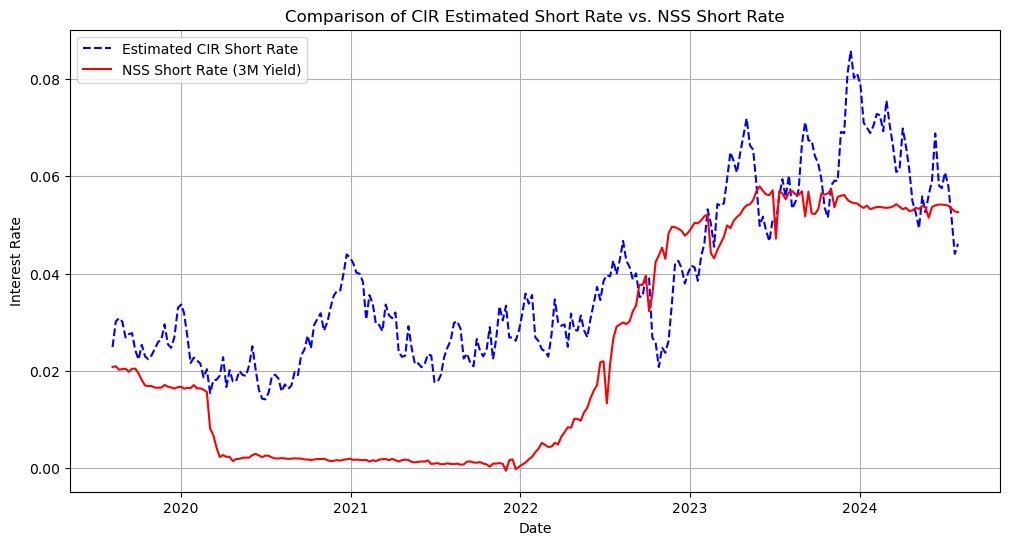

In [132]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm

# Load data (assuming yields_df from previous script)
yields_df = yields_df.dropna()  # Ensure no NaN values

# Define maturities
maturities = np.array([0.25, 0.5, 1, 3, 5, 10, 30])
dt = 1 / 52  # Weekly data

# Initial guesses for parameters
init_params = [0.99, 0.0242, 0.02, 0.01, -0.5]   # [kappa, theta, sigma, A, B]

def cir_kalman_filter(params, yields):
    """Kalman Filter to estimate CIR model parameters"""
    kappa, theta, sigma, A, B = params
    n_obs = len(yields)
    n_mat = len(maturities)
    
    # Initialize state variables
    X_t = np.mean(yields.values[:, 0])  # Start with the mean of short-term yield
    P_t = sigma ** 2  # Initial variance
    log_likelihood = 0
    measurement_error_var = np.zeros(n_mat)  # To store measurement errors

    # Kalman Filter loop
    for t in range(n_obs):
        # Prediction Step
        X_t_pred = X_t + kappa * (theta - X_t) * dt
        P_t_pred = P_t + sigma ** 2 * dt  # Approximate variance update

        # Measurement Equation
        Y_pred = A + B * X_t_pred
        measurement_error = yields.iloc[t, :] - Y_pred
        measurement_error_var += measurement_error ** 2  # Store squared errors

        # Kalman Gain
        R = max(np.var(measurement_error), 1e-8)  # Ensure positive variance
        K = P_t_pred / (P_t_pred + R)  # Kalman gain

        # Update Step
        X_t = X_t_pred + K * np.mean(measurement_error)
        P_t = (1 - K) * P_t_pred

        # Compute log-likelihood
        log_likelihood += norm.logpdf(np.mean(measurement_error), 0, np.sqrt(R))

    # Return negative log-likelihood for minimization
    return -log_likelihood

# Optimize log-likelihood
opt_result = minimize(cir_kalman_filter, init_params, args=(yields_df), method='L-BFGS-B')

# Extract optimized parameters
opt_params = opt_result.x
kappa_hat, theta_hat, sigma_hat, A_hat, B_hat = opt_params

# Compute standard errors from Hessian inverse
hessian_inv = opt_result.hess_inv.todense()
std_errors = np.sqrt(np.diag(hessian_inv))

# Compute measurement error statistics
measurement_errors = yields_df - (A_hat + B_hat * np.mean(yields_df.iloc[:, 0]))
measurement_stats = pd.DataFrame({
    'Mean Error': measurement_errors.mean(),
    'Variance of Error': measurement_errors.var()
}).round(4)

# Display estimated parameters
param_table = pd.DataFrame({
    'Parameter': ['Kappa', 'Theta', 'Sigma', 'A', 'B', 'Log-Likelihood'],
    'Estimate': np.append(opt_params, -opt_result.fun),
    'Standard Error': np.append(std_errors, np.nan)
}).round(4)

print("\nEstimated CIR Model Parameters:")
print(param_table)

print("\nMeasurement Error Statistics:")
print(measurement_stats)

import matplotlib.pyplot as plt

# Extract CIR estimated state process (instantaneous risk-free rate)
X_t_series = np.zeros(len(yields_df))
X_t = np.mean(yields_df.iloc[:, 0])  # Initialize with short rate mean

for t in range(len(yields_df)):
    # Apply CIR state transition equation (discretized)
    X_t = X_t + kappa_hat * (theta_hat - X_t) * dt + sigma_hat * np.sqrt(max(X_t, 1e-8)) * np.random.normal()
    X_t_series[t] = X_t

# Extract NSS short rate (3-month yield)
nss_short_rate = yields_df['0.25y']

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(yields_df.index, X_t_series, label='Estimated CIR Short Rate', linestyle='--', color='blue')
plt.plot(yields_df.index, nss_short_rate, label='NSS Short Rate (3M Yield)', linestyle='-', color='red')
plt.title('Comparison of CIR Estimated Short Rate vs. NSS Short Rate')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.grid(True)
plt.show()
